# Pseudo-node 1 in parallel mode

##### <font color='red'> To do </font>
* Explain the behaviour of RF scores
    * (~) try thousands of trees
* Analyse the _curve_ scoring plots

    * (~) put all the transformations into a function with 'feat_data' as output
    * (~) make an 'input' function taking 'feat_data' and 'cl_names' and returning train_test_split'ed data
    * (!) use _out-of-bag_ score for RF
    * (~) train RF on whole dataset (C60+80+100)vs(fog+gamma) and then perform pair-wise tests!
    * *train_test_split each class before merging*
        * (?) how do we include the direction of recoil (main feature of experiment)?
        * (?) is it ok to train_test_split on each iteration before training?

In [1]:
import numpy as np
import scipy as sp
import time
import os
import shutil
import joblib
from skimage.io import imread
import pandas as pd
from skimage import img_as_float
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import precision_score, make_scorer, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

%matplotlib inline

# Set of functions to fit an image with a gaussian

In [2]:
def gaus_moments(data):
    """Returns a dict containing initial guesses for 2D-Gaussian parameters: 
    (background, amplitude, x_mean, y_mean, sigma_x, sigma_y)
    
    Assuming that image is approximately centered"""
    total = data.sum()
    Y, X = np.indices(data.shape)
    x = data.shape[0]/2 #(X*data).sum()/total
    y = data.shape[1]/2 #(Y*data).sum()/total
    col = data[:, int(y)]
    sigma_y = np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum()
    row = data[int(x), :]
    sigma_x = np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum()
    height = data.min()
    amplitude = data.max() - height
    mom={'background':height, 'amplitude':amplitude, 'x_mean':x, 'y_mean':y, 'sigma_x':sigma_x, 'sigma_y':sigma_y}
    return mom

In [3]:
def twod_gaussian(height, amplitude, center_x, center_y, sig_x, sig_y, sig_xy):
    """Returns a gaussian function with the given parameters"""
    #Sigma = [[sig_x, sig_xy], [sig_xy, sig_y]]
    Sigmin= [[sig_y, -sig_xy], [-sig_xy, sig_x]]/(sig_x*sig_y - sig_xy**2 + 10**-4)
    center = np.array([center_x, center_y]).reshape((1,1,2))
    #print center.shape, Sigmin.shape, center.dot(Sigmin).shape
    return lambda x: height+ amplitude*np.exp(-( (x-center).dot(Sigmin)*(x-center) ).sum(axis=-1)/2)

In [4]:
def fit_gaussian(data):
    """Returns 2D-Gaussian fit parameters:
    (height, amplitude, center_x, center_y, sig_x, sig_y, sig_xy)
    found by a optimizing least squares of an error"""
    mome = gaus_moments(data)
    para = [mome['background'], mome['amplitude'], mome['x_mean'], mome['y_mean'], mome['sigma_x'], mome['sigma_y'], 1.2]
    x = np.stack(np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1])), axis=-1)
    errorfunction = lambda p: np.ravel(twod_gaussian(*p)(x) - data)
    p, success = sp.optimize.leastsq(errorfunction, para)
    #print success
    return p

## Set of functions for processing the data

In [5]:
def load_imgs(dir_name='dust_fog', numb = 10):
    """
    Loading 'numb' of images from 'dir_name'
    and reshaping each one into 8 polarization images of shape 30x30
    -------
    Output:   numpy array of shape 'numb' x 8 x 30 x 30
    """
    dir_name = 'D:/NEWSdm/crops/'+dir_name
    img_arr = []
    num_i = 0
    for img_name in os.listdir(dir_name):
        num_i += 1
        if num_i > numb :
            break
        tmp_im = (pd.read_csv(os.path.join(dir_name, img_name), header=None).drop(30, axis=1)).values.reshape((8,30,30))
        img_arr.append(tmp_im)
    return np.array(img_arr)

In [6]:
def imgs_to_params(imgs):
    """
    Takes array (shape=[numb,8,30,30]) of numb x 8 images of shape 30 x 30
    and fits a 2D Gaussian on each of the images.
    -------
    Output: DataFrame with fitting parameters for images in the array.
    """
    params = pd.DataFrame(columns=['img_num', 'polar', 'height', 'amplitude', 'center_x', 'center_y', 'sig_x', 'sig_y', 'sig_xy'])
    for num in xrange(imgs.shape[0]):
        i=0
        for data in imgs[num]:
            par = np.concatenate(([num+1, i], fit_gaussian(data)))
            par = par.reshape((1,len(par)))
            i += 1
            params = params.append(pd.DataFrame(par,columns=['img_num', 'polar', 'height', 'amplitude', 'center_x', 'center_y', 'sig_x', 'sig_y', 'sig_xy']), ignore_index=True)
    return params

In [7]:
def clean_params(params, up_bound=500):
    """
    Dropping divergent samples (rows) from the dataset.
    Sample is divergent if any parameter (except 'sig_xy') is negative or larger than 'up_bound'
    """
    img_num = params.get('img_num')
    cov_xy = params.get('sig_xy')
    params = params.drop(['img_num','sig_xy'],axis=1)
    params = params[params[params<up_bound]>-0.1]
    params = pd.concat([img_num, params, cov_xy], axis=1, join='inner')
    return params.dropna()

In [8]:
def params_to_features(params):
    """
    Getting physical features from fitting parameters:
    polarization number, amplitude, center position, rotation (represented by 'sig_xy'), minor axis, eccentrisity, area
    -------
    Output: DataFrame with features for every image
    """
    Sigms = params.get(['sig_x','sig_y','sig_xy']).values
    idx = params.index
    #print Sigms.shape
    a_ar = []
    area_ar = []
    eps_ar = []
    for s in Sigms:
        #print s
        a, b = np.linalg.eigvalsh([[s[0],s[2]],[s[2],s[1]]])
        if a>b:
            tmp = a
            a = b
            b = tmp
        a_ar.append(a)
        area_ar.append(np.pi * a * b)
        eps = b/a
        if eps<1: eps = 1/eps
        eps_ar.append(eps)
    ellip_par = pd.DataFrame(data={'minor_ax':a_ar, 'eps':eps_ar, 'area':area_ar}, index=idx)
    #print ellip_par.shape
    feat = params.drop(['img_num','height','sig_x','sig_y'],axis=1)
    feat = pd.concat([feat, ellip_par], axis=1)
    return feat

In [9]:
def feat_to_input(ft_data, cl_names):
    """
    Stacking data with names from 'cl_names' into one DataFrame labeling 'signal' with 1 and 'noise' with 0.
    """
    inp_data = pd.DataFrame(columns=np.concatenate((['target'], ft_data[cl_names[0]].columns.values)) )
    for name in cl_names:
        idx = ft_data[name].index
        if name[0] == 'C' :
            targ = pd.DataFrame(data={'target':np.ones(len(idx))}, index=idx)
        else: targ = pd.DataFrame(data={'target': np.zeros(len(idx))}, index=idx)
        app_data = pd.concat([targ, ft_data[name]], axis=1)
        inp_data = inp_data.append(app_data, ignore_index=True)
    return inp_data    

In [10]:
# should be improved

def load_and_fit_batches(class_name='dust_fog', numb = 10000, node=1, n_cpu=1, n_0 = 1000):
    """
    Loading 'numb' of samples in total from 'class_name' and fitting them with Gaussians and writing results files.
    1. Taking 'n_0' samples at a time and rewriting the same variables on each iteration.
    2. Pseudo-parallelised by running 'n_cpu' applications at once by hands with different 'node' numbers.
    -------
    Output:
    Written 'csv' files with fitting parameters in specific folders, returns 'nump' totall number of samples processed.
    The resulting files are like 'D:/NEWSdm/crops/csvs/batches/50000/gamma/cpu3_n1_it1_params.csv'
    
    *Important*: 'numb' must be devidible by 'n_0', otherwise up to 'n_0' extra samples wil be processe.
    """
    #Getting the number of iterations on this node.
    i_m = np.int(float(numb)/(n_0 * n_cpu))
    over = np.ceil((float(numb) - i_m*n_0*n_cpu)/n_0)
    if node <= over:
        i_m +=1 # each node has it's own i_m
        
    
    dir_name = 'D:/NEWSdm/crops/'+class_name
    nump = 0
    img_names = os.listdir(dir_name)
    for i in range(i_m):
        #iterating over samples in the batch
        img_arr = []
        for img_name in img_names[(node+i-1)*n_0 : (node+i)*n_0]:
            tmp_im = (pd.read_csv(os.path.join(dir_name, img_name), header=None).drop(30, axis=1)).values.reshape((8,30,30))
            img_arr.append(tmp_im)
        img_arr = np.array(img_arr)
        #getting parametrs of samples in the batch and writing tham to file.
        params = pd.DataFrame(columns=['img_num', 'polar', 'height', 'amplitude', 'center_x', 'center_y', 'sig_x', 'sig_y', 'sig_xy'])
        for img_num in np.arange(img_arr.shape[0]):
            polar=1
            for data in img_arr[img_num]:
                par = np.concatenate(([img_num+1, polar], fit_gaussian(data)))
                par = par.reshape((1,len(par)))
                polar += 1
                nump += 1
                params = params.append(pd.DataFrame(par,columns=['img_num', 'polar', 'height', 'amplitude', 'center_x', 'center_y', 'sig_x', 'sig_y', 'sig_xy']), ignore_index=True)
        output_name = str(numb)+'/'+class_name+'/cpu'+str(n_cpu)+'_n'+str(node)+'_it'+str(i+1)+'_params'
        params.to_csv('D:/NEWSdm/crops/csvs/batches/'+output_name+'.csv')
    '''
    Пофиксить что самая последняя итерация выбегает за пределы, если не делится нацело.
    '''
    return nump

In [11]:
def read_params_from_names(numb, name):
    """
    Reading and stacking DataFrames with parameters from the specified directory: 
    D:/NEWSdm/crops/csvs/batches/'numb'/name
    """
    dir_name = 'D:/NEWSdm/crops/csvs/batches/'+str(numb)+'/'+name
    params = pd.DataFrame(columns=['img_num', 'polar', 'height', 'amplitude', 'center_x', 'center_y', 'sig_x', 'sig_y', 'sig_xy'])
    for img_name in os.listdir(dir_name):
        par = pd.read_csv(os.path.join(dir_name, img_name), index_col=0)
        params = params.append(par, ignore_index=True)
    return params

In [13]:
def load_params_to_feat(numb, cl_names, giant=False):
    """
    Reading parameters from files, cleaning them and transforming into features.
    -------
    Output: Dict with features DataFrame for every class name
    """
    dat_params = {}
    ft_data = {}
    for name in cl_names:
        if giant:
            dat_params[name] = read_params_from_names(numb, name)
        else: dat_params[name] = pd.read_csv('D:/NEWSdm/crops/csvs/'+str(numb)+'_'+name+'_params.csv', index_col=0)
        ft_data[name] = params_to_features( clean_params(dat_params[name]) )
    return ft_data

In [14]:
def feat_to_input_split(ft_data, cl_names, test_size=0.1):
    """
    Stacking data from specified class names together, getting a target variable and performing a train-test split.
    -------
    Output: X_train, X_test, y_train, y_test
    """
    inp_data = feat_to_input(ft_data, cl_names)
    X = inp_data.drop(['target'], axis=1).values
    y = inp_data.get('target').values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

In [12]:
class_names = ['C60keV','C80keV','C100keV','dust_fog','gamma']

## Training on 1000 samples of each type

##### Loading images, fitting with Gaussians and saving to files
> _Markdown_, because we have already performed this transformation

```
%%time
##### Loading images from the _csv_ files.

numb = 1000
data_imgs = {}
for name in class_names:
    data_imgs[name] = load_imgs(name, numb)

print data_imgs['gamma'].shape

##### Fitting each image with a 2D Gaussian.

data_params = {}
for name in class_names:
    data_params[name] = imgs_to_params(data_imgs[name])


##### Saving data parameters to files for later use

for (key, value) in data_params.iteritems():
    value.to_csv('D:/NEWSdm/crops/csvs/1000_'+key+'_params.csv')
```

##### Loading files with Gaussian parameters and transforming them to input features

In [13]:
%%time
##### Loading previously saved parameters

data_params = {}
for name in class_names:
    data_params[name] = pd.read_csv('D:/NEWSdm/crops/csvs/1000_'+name+'_params.csv', index_col=0)    

##### Droping the samples where fit diverges

cleaned_data = {}
for name in class_names:
    cleaned_data[name] = clean_params(data_params[name])

print 'cleaned data shape'    
for (key,value) in cleaned_data.iteritems():
    print key,'  \t', value.shape

##### Transforming fitting parameters into physical features of the image

feat_data = {}
for name in class_names:
    feat_data[name] = params_to_features(cleaned_data[name])
    
#print '\n', feat_data['C100keV'].head(1)

##### Merging all data into one DataFrame with appropriate target labels (signal/noise)

input_data = feat_to_input(feat_data, class_names)
print '\n', input_data.head(1)

#### Spliting data into train and test
# * Precision is the scorer

X = input_data.drop(['target'], axis=1).values
y = input_data.get('target').values
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

prec_scorer = make_scorer(precision_score)

cleaned data shape
C80keV   	(5982, 9)
C60keV   	(5628, 9)
C100keV   	(7691, 9)
gamma   	(7614, 9)
dust_fog   	(7211, 9)

   target  polar  amplitude   center_x   center_y    sig_xy        area  \
0     1.0    0.0  13.193473  13.938397  15.056143 -0.127071  112.693171   

        eps  minor_ax  
0  1.117186  5.666451  
Wall time: 3.53 s


### Training LogisticRegression

In [14]:
%%time
logregCV = LogisticRegressionCV(scoring=prec_scorer)
logregCV.fit(X_train_scaled, y_train)

for a in zip(logregCV.Cs_ , logregCV.scores_[1].mean(axis=0)):
    print 'C= %.2e' %a[0], '\t score= %.5g' %a[1]

C= 1.00e-04 	 score= 0.56559
C= 7.74e-04 	 score= 0.56562
C= 5.99e-03 	 score= 0.56754
C= 4.64e-02 	 score= 0.57015
C= 3.59e-01 	 score= 0.57054
C= 2.78e+00 	 score= 0.57047
C= 2.15e+01 	 score= 0.57047
C= 1.67e+02 	 score= 0.57047
C= 1.29e+03 	 score= 0.57047
C= 1.00e+04 	 score= 0.57047
Wall time: 2.27 s


### Training Boosted Decision Trees

##### CV with precision

In [15]:
%%time
boocla = GradientBoostingClassifier()
boo_scores = []
boo_var = []
n_est = [10, 50, 100, 200, 500, 1000]
for n in n_est:
    boocla.set_params(n_estimators=n)
    sco = cross_val_score(boocla, X_train_scaled, y_train, scoring=prec_scorer, n_jobs=2, cv=5)
    boo_scores.append(sco.mean())
    boo_var.append(sco.var())
    print np.around(sco.mean(),decimals=3), '+/-', np.around(100*sco.var()/sco.mean(), decimals=3), '%'

0.617 +/- 0.0 %
0.681 +/- 0.0 %
0.718 +/- 0.004 %
0.748 +/- 0.001 %
0.802 +/- 0.001 %
0.853 +/- 0.001 %
Wall time: 5min 7s


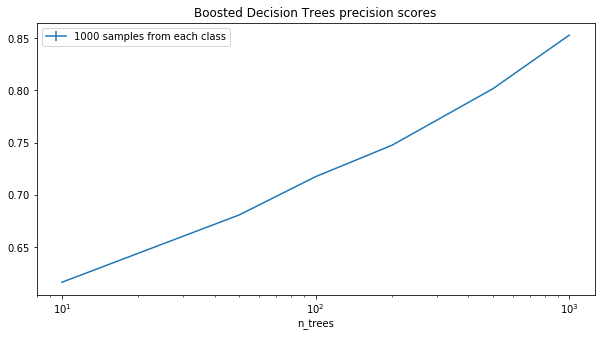

In [16]:
n_est = [10, 50, 100, 200, 500, 1000]
plt.figure(figsize=(10,5))
#plt.plot(n_est, boo_scores, label='1000 samples from each class')
plt.errorbar(n_est, boo_scores, yerr=boo_var, label='1000 samples from each class')
plt.title('Boosted Decision Trees precision scores')
plt.xlabel('n_trees')
plt.xscale('log')
plt.legend()
plt.savefig('BDT_cv_1k.pdf')

##### AUC-ROC and Precision-Recall curves

AUC_ROC scores
C60keV__dust_fog   	0.991
C60keV__gamma   	0.99
C80keV__gamma   	0.961
C80keV__dust_fog   	0.997
C100keV__gamma   	0.985
C100keV__dust_fog   	0.99
Wall time: 2min 17s


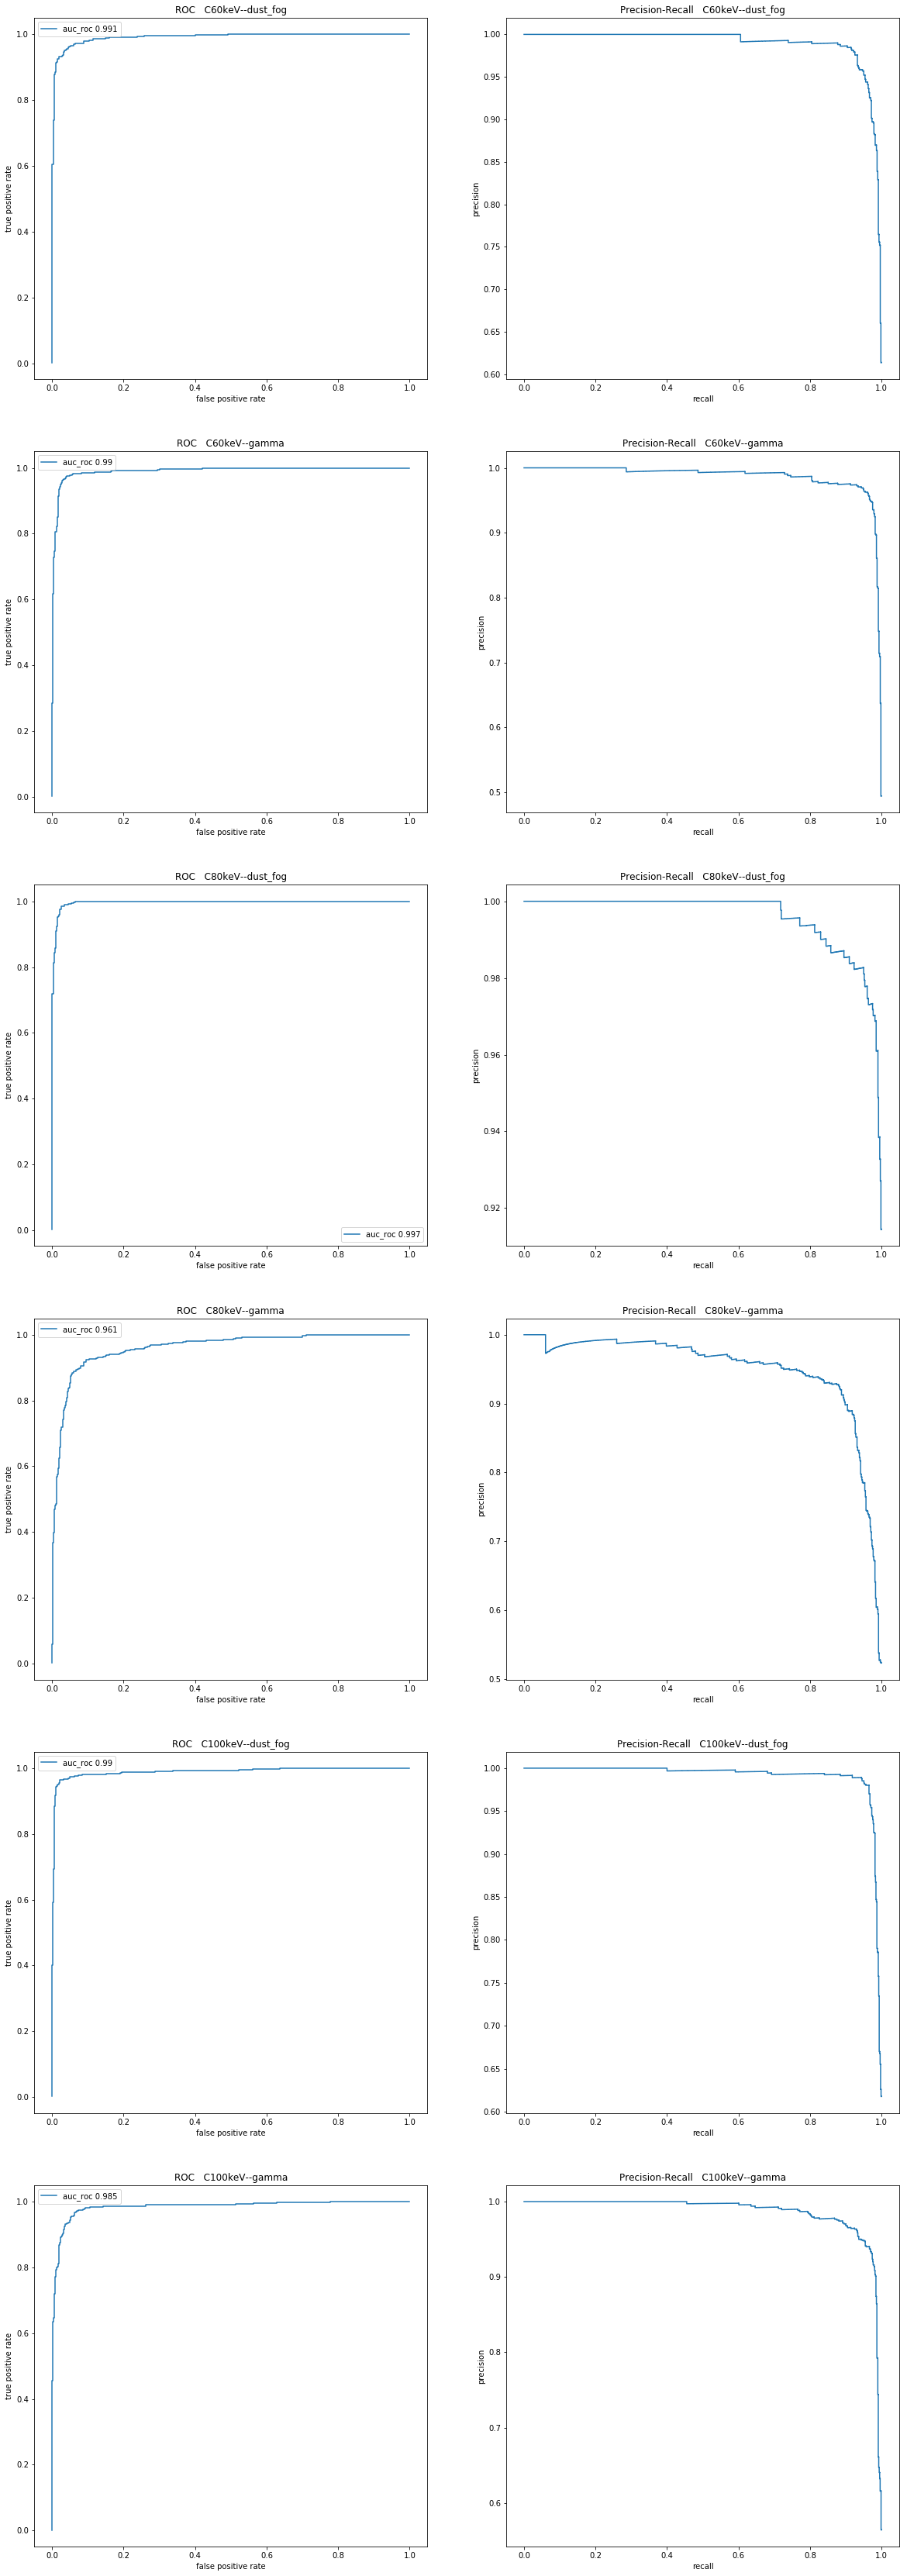

In [17]:
%%time
# Taking the best number of estimators from CV
boocla.set_params(n_estimators = n_est[np.argmax(boo_scores)])
#boocla = GradientBoostingClassifier(n_estimators=500)

f, axes = plt.subplots(6, 2, figsize=(20, 60))
axes = axes.ravel()
i=0
auc_rocs = {}
##### Creating the pairs of signal-noise for comparison
for name1 in class_names:
    for name2 in class_names:
        if (name1[0] == 'C') and (name2[0] != 'C'):
            input_data = feat_to_input(feat_data, [name1, name2])
            X = input_data.drop(['target'], axis=1).values
            y = input_data.get('target').values
            X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_raw)
            X_test_scaled = scaler.transform(X_test_raw)
            ##### Scoring the BDT and building curves
            boocla.fit(X_train_scaled, y_train)
            boo_pred = (boocla.predict_proba(X_test_scaled))[:,1]
            auc_rocs[name1+'__'+name2] = roc_auc_score(y_test, boo_pred)
            fpr, tpr, thrsh = roc_curve(y_test, boo_pred)
            axes[i].step(fpr, tpr, label='auc_roc '+str(np.around(auc_rocs[name1+'__'+name2], decimals=3)))
            axes[i].set_title('ROC   '+name1+'--'+name2)
            axes[i].set_xlabel('false positive rate')
            axes[i].set_ylabel('true positive rate')
            axes[i].legend()
            i += 1
            prec, rec, thrsh = precision_recall_curve(y_test, boo_pred)
            axes[i].step(rec, prec)
            axes[i].set_title('Precision-Recall   '+name1+'--'+name2)
            axes[i].set_xlabel('recall')
            axes[i].set_ylabel('precision')
            i += 1
            
            
print 'AUC_ROC scores'
for (key,value) in auc_rocs.iteritems():
    print key,'  \t', np.around(value, decimals=3)

### Training Random Forest

In [18]:
%%time
randcla = RandomForestClassifier()
rand_scores = []
rand_var = []
n_est = [10, 20, 50, 100, 200]
for n in n_est:
    randcla.set_params(n_estimators=n)
    sco = cross_val_score(randcla, X_train_scaled, y_train, scoring=prec_scorer, n_jobs=2, cv=5)
    rand_scores.append(sco.mean())
    rand_var.append(sco.var())
    print np.around(sco.mean(),decimals=3), '+/-', np.around(100*sco.var()/sco.mean(), decimals=3), '%'

0.978 +/- 0.002 %
0.979 +/- 0.001 %
0.977 +/- 0.001 %
0.98 +/- 0.001 %
0.981 +/- 0.002 %
Wall time: 1min 4s


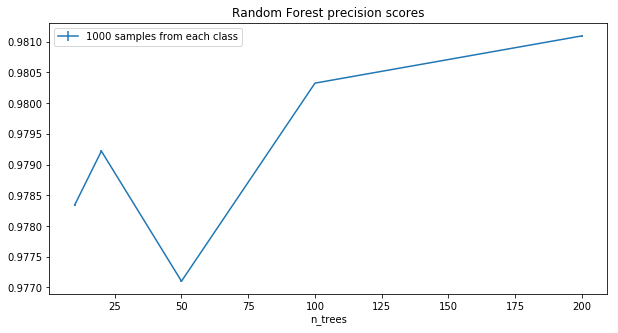

In [19]:
n_est = [10, 20, 50, 100, 200]
plt.figure(figsize=(10,5))
plt.errorbar(n_est, rand_scores, yerr=rand_var, label='1000 samples from each class')
plt.title('Random Forest precision scores')
plt.xlabel('n_trees')
plt.legend()
plt.savefig('RF_cv_1k.pdf')

##### AUC-ROC and Precision-Recall curves

AUC_ROC scores
C60keV__dust_fog   	0.9983
C60keV__gamma   	0.9967
C80keV__gamma   	0.9939
C80keV__dust_fog   	0.9978
C100keV__gamma   	0.999
C100keV__dust_fog   	0.9988
Wall time: 1min 4s


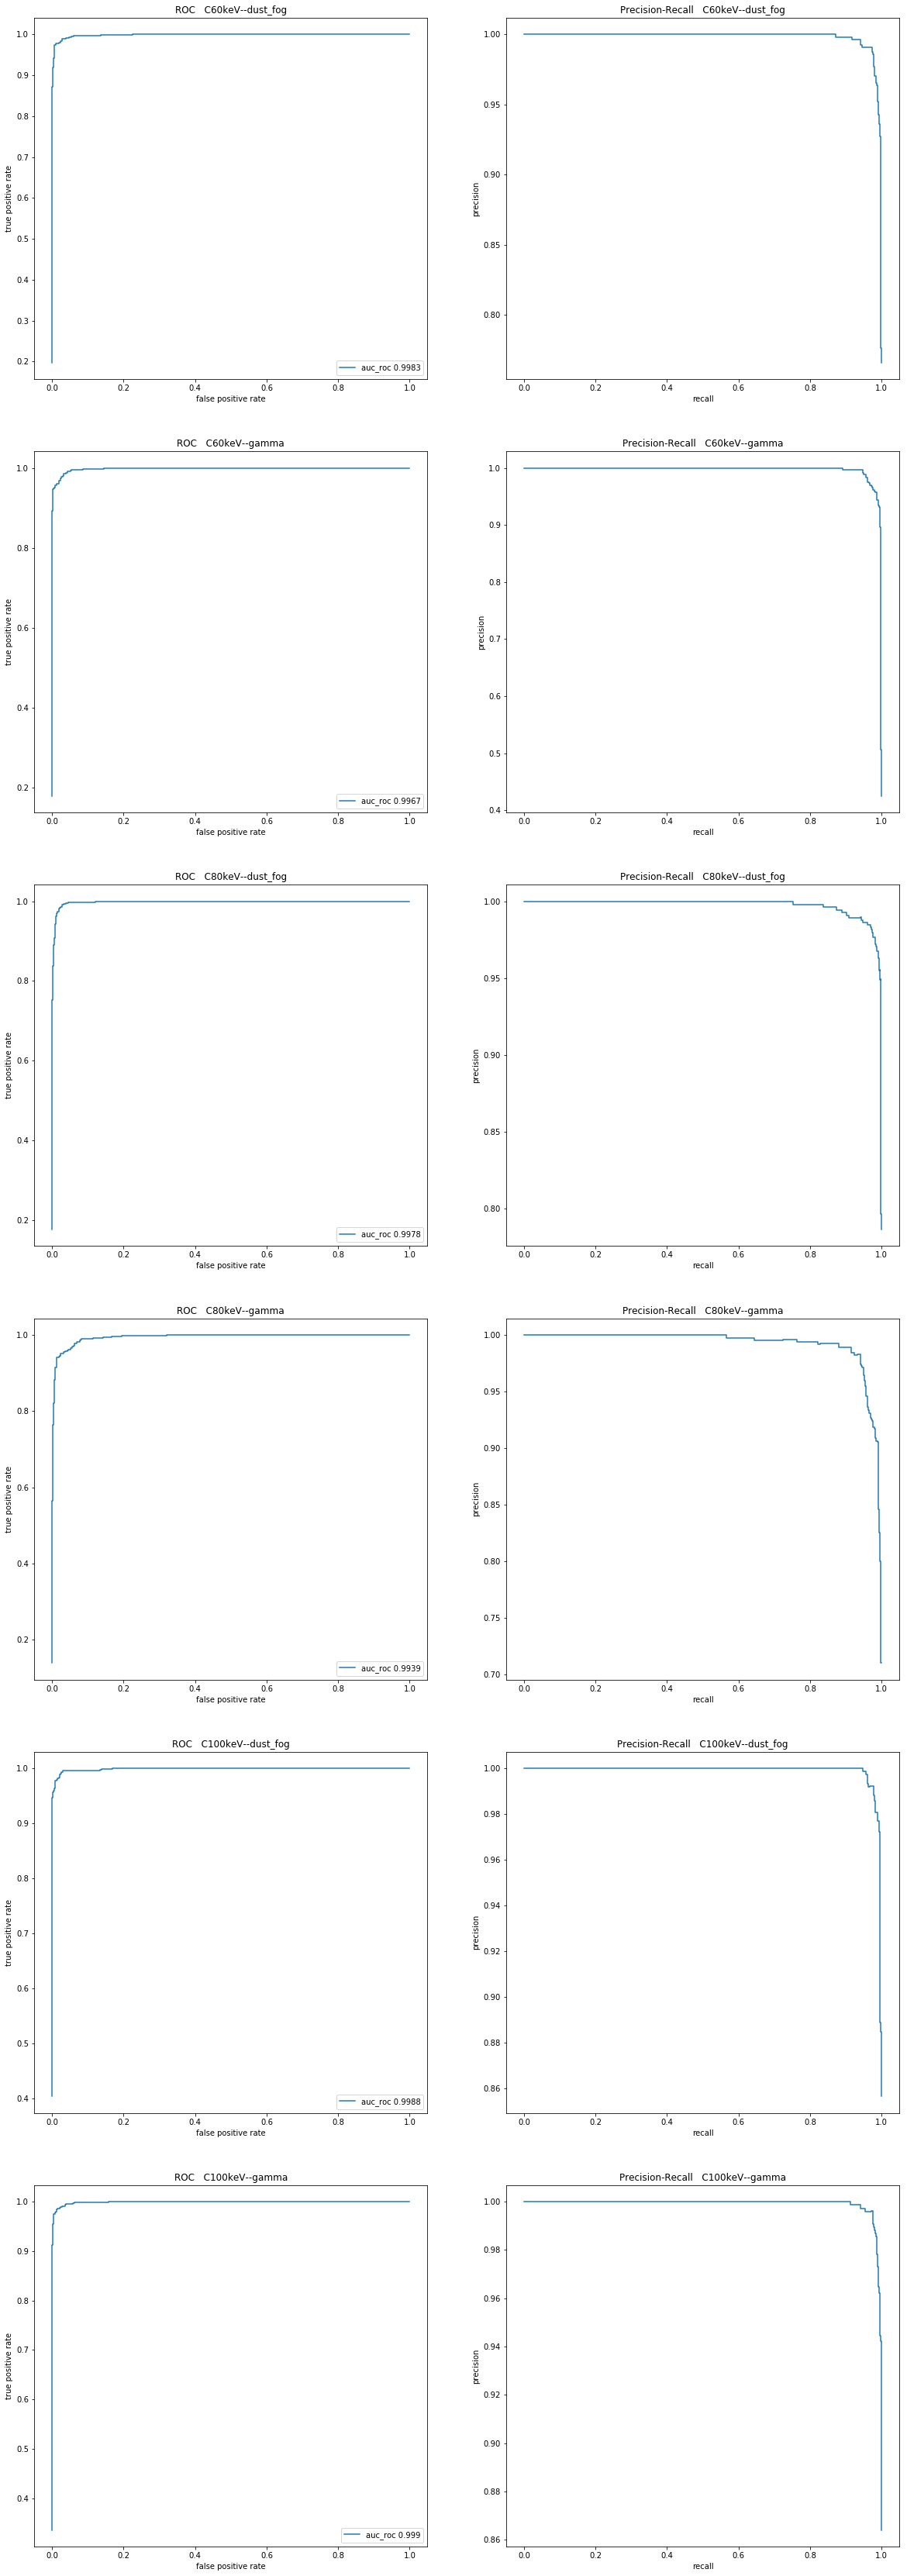

In [20]:
%%time
# Taking the best number of estimators from CV
randcla.set_params(n_estimators = n_est[np.argmax(rand_scores)])
#randcla = RandomForestClassifier(n_estimators=100)

f, axes = plt.subplots(6, 2, figsize=(20, 60))
axes = axes.ravel()
i=0
auc_rocs = {}
##### Creating the pairs of signal-noise for comparison
for name1 in class_names:
    for name2 in class_names:
        if (name1[0] == 'C') and (name2[0] != 'C'):
            input_data = feat_to_input(feat_data, [name1, name2])
            X = input_data.drop(['target'], axis=1).values
            y = input_data.get('target').values
            X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_raw)
            X_test_scaled = scaler.transform(X_test_raw)
            ##### Scoring the RF and building curves
            randcla.fit(X_train_scaled, y_train)
            rand_pred = (randcla.predict_proba(X_test_scaled))[:,1]
            auc_rocs[name1+'__'+name2] = roc_auc_score(y_test, rand_pred)
            fpr, tpr, thrsh = roc_curve(y_test, rand_pred)
            axes[i].step(fpr, tpr, label='auc_roc '+str(np.around(auc_rocs[name1+'__'+name2], decimals=4)))
            axes[i].set_title('ROC   '+name1+'--'+name2)
            axes[i].set_xlabel('false positive rate')
            axes[i].set_ylabel('true positive rate')
            axes[i].legend()
            i += 1
            prec, rec, thrsh = precision_recall_curve(y_test, rand_pred)
            axes[i].step(rec, prec)
            axes[i].set_title('Precision-Recall   '+name1+'--'+name2)
            axes[i].set_xlabel('recall')
            axes[i].set_ylabel('precision')
            i += 1
            
            
print 'AUC_ROC scores'
for (key,value) in auc_rocs.iteritems():
    print key,'  \t', np.around(value, decimals=4)

## Training on 5000 samples of each type

##### Loading images, fitting with Gaussians and saving to files

```
%%time
##### Loading images from the _csv_ files.

numb = 5000
big_data_imgs = {}
for name in class_names:
    big_data_imgs[name] = load_imgs(name, numb)
    
print big_data_imgs['gamma'].shape

##### Fitting each image with a 2D Gaussian.

big_data_params = {}
for name in class_names:
    big_data_params[name] = imgs_to_params(big_data_imgs[name])

##### Saving data parameters to files for later use

for (key, value) in big_data_params.iteritems():
    value.to_csv('D:/NEWSdm/crops/csvs/5000_'+key+'_params.csv')
```

##### Loading files with Gaussian parameters and transforming them to input features

In [21]:
%%time
##### Loading previously saved parameters

big_data_params = {}
for name in class_names:
    big_data_params[name] = pd.read_csv('D:/NEWSdm/crops/csvs/5000_'+name+'_params.csv', index_col=0)

##### Droping the samples where fit diverges

cleaned_big_data = {}
for name in class_names:
    cleaned_big_data[name] = clean_params(big_data_params[name])

print 'cleaned data shape'
for (key,value) in cleaned_big_data.iteritems():
    print key,'  \t', value.shape

##### Transforming fitting parameters into physical features of the image

feat_big_data = {}
for name in class_names:
    feat_big_data[name] = params_to_features(cleaned_big_data[name])


##### Merging all data into one DataFrame with appropriate target labels (signal/noise)

input_big_data = feat_to_input(feat_big_data, class_names)


#### Spliting data into train and test
# * Precision is the scorer

X_big = input_big_data.drop(['target'], axis=1).values
y_big = input_big_data.get('target').values
X_train_big_raw, X_test_big_raw, y_train_big, y_test_big = train_test_split(X_big, y_big, test_size=0.1, stratify=y_big)
scaler = StandardScaler()
X_train_big_scaled = scaler.fit_transform(X_train_big_raw)
X_test_big_scaled = scaler.transform(X_test_big_raw)

prec_scorer = make_scorer(precision_score)

cleaned data shape
C80keV   	(26058, 9)
C60keV   	(29323, 9)
C100keV   	(38169, 9)
gamma   	(36576, 9)
dust_fog   	(36589, 9)
Wall time: 14.5 s


### Training LogisticRegression

In [22]:
%%time
big_logregCV = LogisticRegressionCV(scoring=prec_scorer)
big_logregCV.fit(X_train_big_scaled, y_train_big)

for a in zip(big_logregCV.Cs_ , big_logregCV.scores_[1].mean(axis=0)):
    print 'C= %.2e' %a[0], '\t score= %.5g' %a[1]

C= 1.00e-04 	 score= 0.56115
C= 7.74e-04 	 score= 0.56143
C= 5.99e-03 	 score= 0.56177
C= 4.64e-02 	 score= 0.56182
C= 3.59e-01 	 score= 0.56181
C= 2.78e+00 	 score= 0.56182
C= 2.15e+01 	 score= 0.56181
C= 1.67e+02 	 score= 0.56182
C= 1.29e+03 	 score= 0.56182
C= 1.00e+04 	 score= 0.56181
Wall time: 7.44 s


### Training Boosted Decision Trees

In [23]:
%%time
boocla = GradientBoostingClassifier()
big_scores = []
big_var = []
n_est = [10, 50, 100, 200, 500, 1000]
for n in n_est:
    boocla.set_params(n_estimators=n)
    sco = cross_val_score(boocla, X_train_big_scaled, y_train_big, scoring=prec_scorer, n_jobs=2, cv=5)
    big_scores.append(sco.mean())
    big_var.append(sco.var())
    print np.around(sco.mean(),decimals=3), '+/-', np.around(100*sco.var()/sco.mean(), decimals=3), '%'

0.628 +/- 0.002 %
0.645 +/- 0.001 %
0.651 +/- 0.0 %
0.662 +/- 0.001 %
0.694 +/- 0.001 %
0.722 +/- 0.0 %
Wall time: 34min 48s


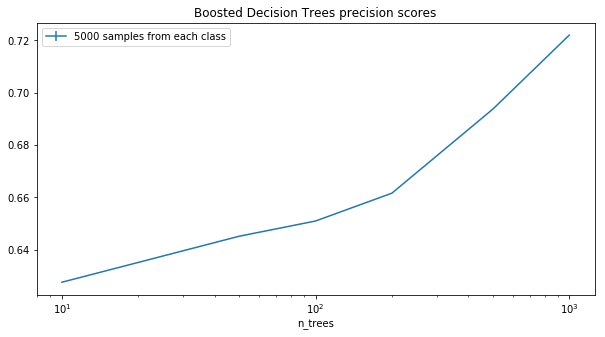

In [24]:
n_est = [10, 50, 100, 200, 500, 1000]
plt.figure(figsize=(10,5))
plt.errorbar(n_est, big_scores, yerr=big_var, label='5000 samples from each class')
plt.title('Boosted Decision Trees precision scores')
plt.xlabel('n_trees')
plt.xscale('log')
plt.legend()
plt.savefig('BDT_cv_5k.pdf')

##### AUC-ROC and Precision-Recall curves

AUC_ROC scores
C60keV__dust_fog   	0.91067
C60keV__gamma   	0.91991
C80keV__gamma   	0.88933
C80keV__dust_fog   	0.97657
C100keV__gamma   	0.89876
C100keV__dust_fog   	0.92445
Wall time: 13min 16s


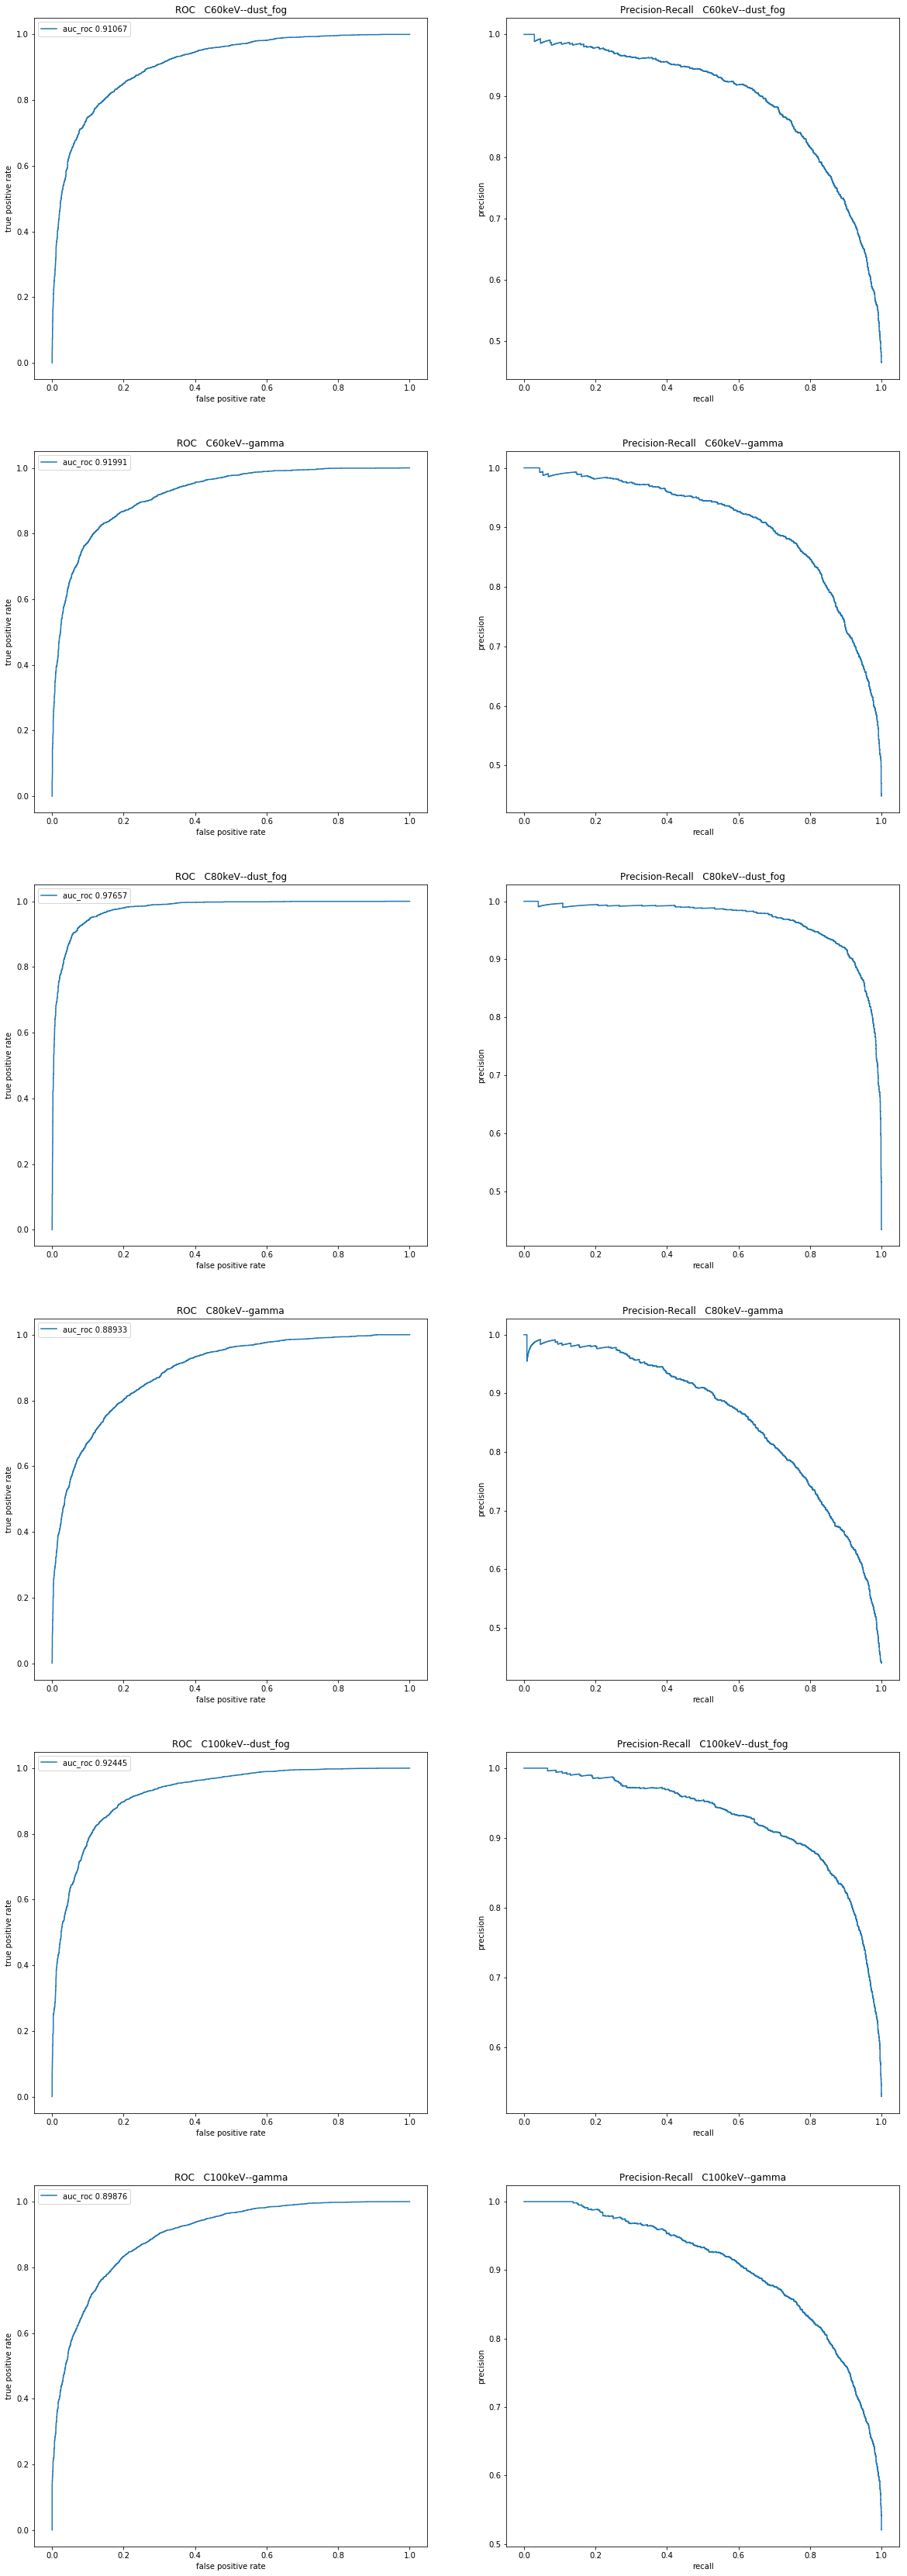

In [25]:
%%time
# Taking the best number of estimators from CV
boocla.set_params(n_estimators = n_est[np.argmax(big_scores)])
#boocla = GradientBoostingClassifier(n_estimators=500)

f, axes = plt.subplots(6, 2, figsize=(20, 60))
axes = axes.ravel()
i=0
auc_rocs = {}
##### Creating the pairs of signal-noise for comparison
for name1 in class_names:
    for name2 in class_names:
        if (name1[0] == 'C') and (name2[0] != 'C'):
            input_data = feat_to_input(feat_big_data, [name1, name2])
            X = input_data.drop(['target'], axis=1).values
            y = input_data.get('target').values
            X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_raw)
            X_test_scaled = scaler.transform(X_test_raw)
            ##### Scoring the BDT and building curves
            boocla.fit(X_train_scaled, y_train)
            boo_pred = (boocla.predict_proba(X_test_scaled))[:,1]
            auc_rocs[name1+'__'+name2] = roc_auc_score(y_test, boo_pred)
            fpr, tpr, thrsh = roc_curve(y_test, boo_pred)
            axes[i].step(fpr, tpr, label='auc_roc '+str(np.around(auc_rocs[name1+'__'+name2], decimals=5)))
            axes[i].set_title('ROC   '+name1+'--'+name2)
            axes[i].set_xlabel('false positive rate')
            axes[i].set_ylabel('true positive rate')
            axes[i].legend()
            i += 1
            prec, rec, thrsh = precision_recall_curve(y_test, boo_pred)
            axes[i].step(rec, prec)
            axes[i].set_title('Precision-Recall   '+name1+'--'+name2)
            axes[i].set_xlabel('recall')
            axes[i].set_ylabel('precision')
            i += 1
            
            
print 'AUC_ROC scores'
for (key,value) in auc_rocs.iteritems():
    print key,'  \t', np.around(value, decimals=5)

### Training Random Forest

In [26]:
%%time
randcla = RandomForestClassifier()
big_rand_scores = []
big_rand_var = []
n_est = [10, 20, 50, 100, 200]
for n in n_est:
    randcla.set_params(n_estimators=n)
    sco = cross_val_score(randcla, X_train_big_scaled, y_train_big, scoring=prec_scorer, n_jobs=2, cv=5)
    big_rand_scores.append(sco.mean())
    big_rand_var.append(sco.var())
    print np.around(sco.mean(),decimals=3), '+/-', np.around(100*sco.var()/sco.mean(), decimals=3), '%'

0.95 +/- 0.0 %
0.949 +/- 0.0 %
0.948 +/- 0.0 %
0.948 +/- 0.0 %
0.948 +/- 0.0 %
Wall time: 16min 40s


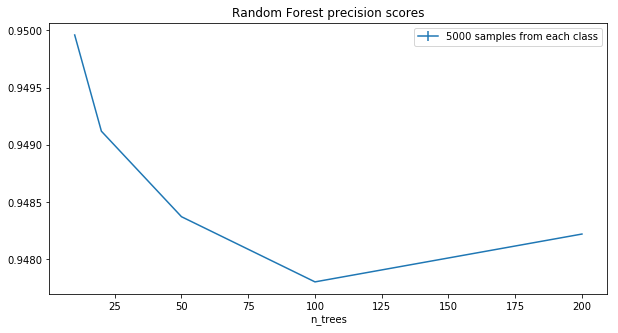

In [27]:
n_est = [10, 20, 50, 100, 200]
plt.figure(figsize=(10,5))
plt.errorbar(n_est, big_rand_scores, yerr=big_rand_var, label='5000 samples from each class')
plt.title('Random Forest precision scores')
plt.xlabel('n_trees')
plt.legend()
plt.savefig('RF_cv_5k.pdf')

##### AUC-ROC and Precision-Recall curves

AUC_ROC scores
C60keV__dust_fog   	0.992881
C60keV__gamma   	0.994943
C80keV__gamma   	0.989038
C80keV__dust_fog   	0.995198
C100keV__gamma   	0.994958
C100keV__dust_fog   	0.996335
Wall time: 22.4 s


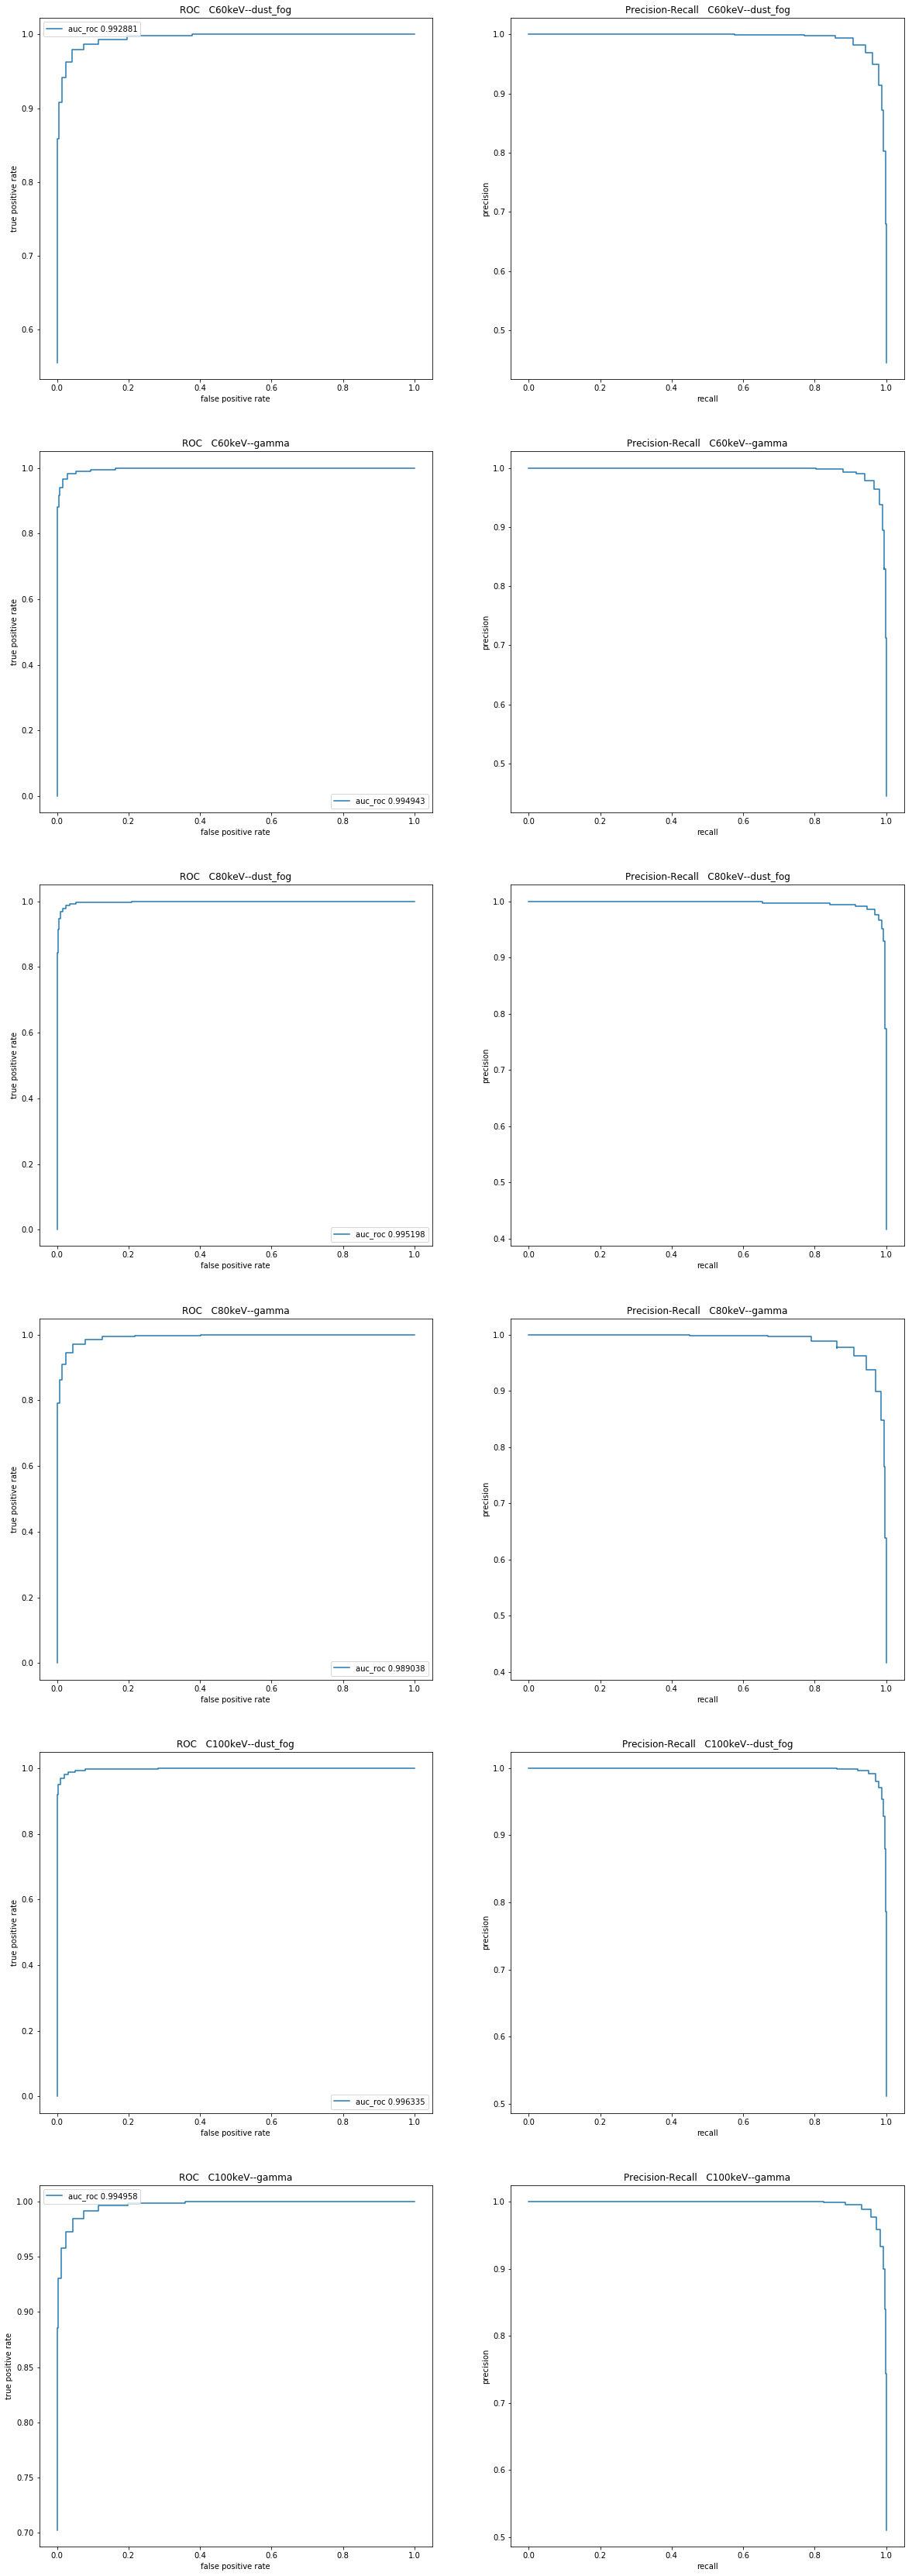

In [28]:
%%time
# Taking the best number of estimators from CV
randcla.set_params(n_estimators = n_est[np.argmax(big_rand_scores)])
#randcla = RandomForestClassifier(n_estimators=100)

f, axes = plt.subplots(6, 2, figsize=(20, 60))
axes = axes.ravel()
i=0
auc_rocs = {}
##### Creating the pairs of signal-noise for comparison
for name1 in class_names:
    for name2 in class_names:
        if (name1[0] == 'C') and (name2[0] != 'C'):
            input_data = feat_to_input(feat_big_data, [name1, name2])
            X = input_data.drop(['target'], axis=1).values
            y = input_data.get('target').values
            X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_raw)
            X_test_scaled = scaler.transform(X_test_raw)
            ##### Scoring the RF and building curves
            randcla.fit(X_train_scaled, y_train)
            rand_pred = (randcla.predict_proba(X_test_scaled))[:,1]
            auc_rocs[name1+'__'+name2] = roc_auc_score(y_test, rand_pred)
            fpr, tpr, thrsh = roc_curve(y_test, rand_pred)
            axes[i].step(fpr, tpr, label='auc_roc '+str(np.around(auc_rocs[name1+'__'+name2], decimals=6)))
            axes[i].set_title('ROC   '+name1+'--'+name2)
            axes[i].set_xlabel('false positive rate')
            axes[i].set_ylabel('true positive rate')
            axes[i].legend()
            i += 1
            prec, rec, thrsh = precision_recall_curve(y_test, rand_pred)
            axes[i].step(rec, prec)
            axes[i].set_title('Precision-Recall   '+name1+'--'+name2)
            axes[i].set_xlabel('recall')
            axes[i].set_ylabel('precision')
            i += 1
            
            
print 'AUC_ROC scores'
for (key,value) in auc_rocs.iteritems():
    print key,'  \t', np.around(value, decimals=6)

## Training on 20k samples of each type

In [29]:
repeated = False

##### Fitting the images and saving parameters into files
* _repeated_ is for recreating the output directory if you are running the same number of samples not for the first time
* 20000 images on two nodes ~14hours

```
%%time
numb = 20000
if repeated:
    shutil.rmtree('D:/NEWSdm/crops/csvs/batches/'+str(numb)+'/')
os.mkdir('D:/NEWSdm/crops/csvs/batches/'+str(numb)+'/')
giant_data_numb = {}
for name in class_names:
    os.mkdir('D:/NEWSdm/crops/csvs/batches/'+str(numb)+'/'+name+'/')
    repeated = True
    giant_data_numb[name] = load_and_fit_batches(class_name=name, numb=numb, node=1, n_cpu=2)
```

##### Loading files with Gaussian parameters and transforming them to input features

In [30]:
%%time
##### Loading previosly saved parameters
numb = 20000

giant_data_params = {}
for name in class_names:
    giant_data_params[name] = read_params_from_names(numb, name)


##### Droping the samples where fit diverges

cleaned_giant_data = {}
for name in class_names:
    cleaned_giant_data[name] = clean_params(giant_data_params[name])


print 'cleaned data shape'

for (key,value) in cleaned_giant_data.iteritems():
    print key,'  \t', value.shape

##### Transforming fitting parameters into physical features of the image

feat_giant_data = {}
for name in class_names:
    feat_giant_data[name] = params_to_features(cleaned_giant_data[name])
    
##### Merging all data into one DataFrame with appropriate target labels (signal/noise)

input_giant_data = feat_to_input(feat_giant_data, class_names)

print input_giant_data.shape, '\n\n', input_giant_data.head(1)

#### Spliting data into train and test
# * Precision is the scorer

X_giant = input_giant_data.drop(['target'], axis=1).values
y_giant = input_giant_data.get('target').values
X_giant_train_raw, X_giant_test_raw, y_giant_train, y_giant_test = train_test_split(X_giant, y_giant, test_size=0.1, stratify=y_giant)
scaler = StandardScaler()
X_giant_train_scaled = scaler.fit_transform(X_giant_train_raw)
X_giant_test_scaled = scaler.transform(X_giant_test_raw)

prec_scorer = make_scorer(precision_score)

cleaned data shape
C80keV   	(103120, 9)
C60keV   	(131882, 9)
C100keV   	(147112, 9)
gamma   	(145463, 9)
dust_fog   	(120896, 9)
(648473, 9) 

   target  polar  amplitude   center_x   center_y    sig_xy       area  \
0     1.0    1.0   5.108879  14.329652  14.817351  0.001597  87.683335   

        eps  minor_ax  
0  1.844835  3.889599  
Wall time: 54.9 s


### Training LogisticRegression

In [31]:
%%time
giant_logregCV = LogisticRegressionCV(scoring=prec_scorer)
giant_logregCV.fit(X_giant_train_scaled, y_giant_train)

for a in zip(giant_logregCV.Cs_ , giant_logregCV.scores_[1].mean(axis=0)):
    print 'C= %.2e' %a[0], '\t score= %.5g' %a[1]

C= 1.00e-04 	 score= 0.58903
C= 7.74e-04 	 score= 0.58938
C= 5.99e-03 	 score= 0.58967
C= 4.64e-02 	 score= 0.58969
C= 3.59e-01 	 score= 0.58969
C= 2.78e+00 	 score= 0.58968
C= 2.15e+01 	 score= 0.58968
C= 1.67e+02 	 score= 0.58968
C= 1.29e+03 	 score= 0.58968
C= 1.00e+04 	 score= 0.58968
Wall time: 26.1 s


### Training Boosted Decision Trees

In [32]:
%%time
boocla = GradientBoostingClassifier()
giant_scores = []
giant_var = []
n_est = [10, 50, 100, 200, 500, 1000]
for n in n_est:
    boocla.set_params(n_estimators=n)
    sco = cross_val_score(boocla, X_giant_train_scaled, y_giant_train, scoring=prec_scorer, n_jobs=2, cv=5)
    giant_scores.append(sco.mean())
    giant_var.append(sco.var())
    print np.around(sco.mean(),decimals=3), '+/-', np.around(100*sco.var()/sco.mean(), decimals=3), '%'

0.646 +/- 0.0 %
0.665 +/- 0.0 %
0.669 +/- 0.0 %
0.672 +/- 0.0 %
0.683 +/- 0.0 %
0.696 +/- 0.0 %
Wall time: 2h 51min 45s


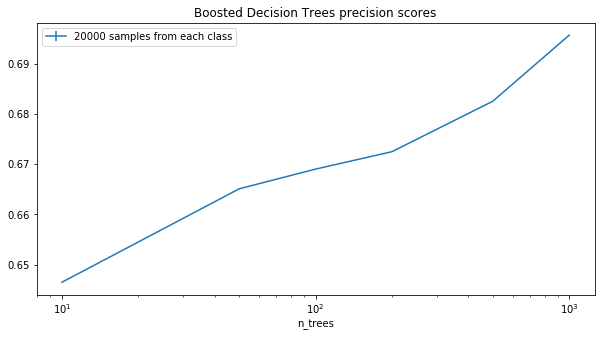

In [33]:
n_est = [10, 50, 100, 200, 500, 1000]
plt.figure(figsize=(10,5))
plt.errorbar(n_est, giant_scores, yerr=giant_var, label='20000 samples from each class')
plt.title('Boosted Decision Trees precision scores')
plt.xlabel('n_trees')
plt.xscale('log')
plt.legend()
plt.savefig('BDT_cv_20k.pdf')

##### AUC-ROC and Precision-Recall curves

AUC_ROC scores
C60keV__dust_fog   	0.854469
C60keV__gamma   	0.857074
C80keV__gamma   	0.852621
C80keV__dust_fog   	0.954988
C100keV__gamma   	0.853912
C100keV__dust_fog   	0.887909
Wall time: 1h 9min 6s


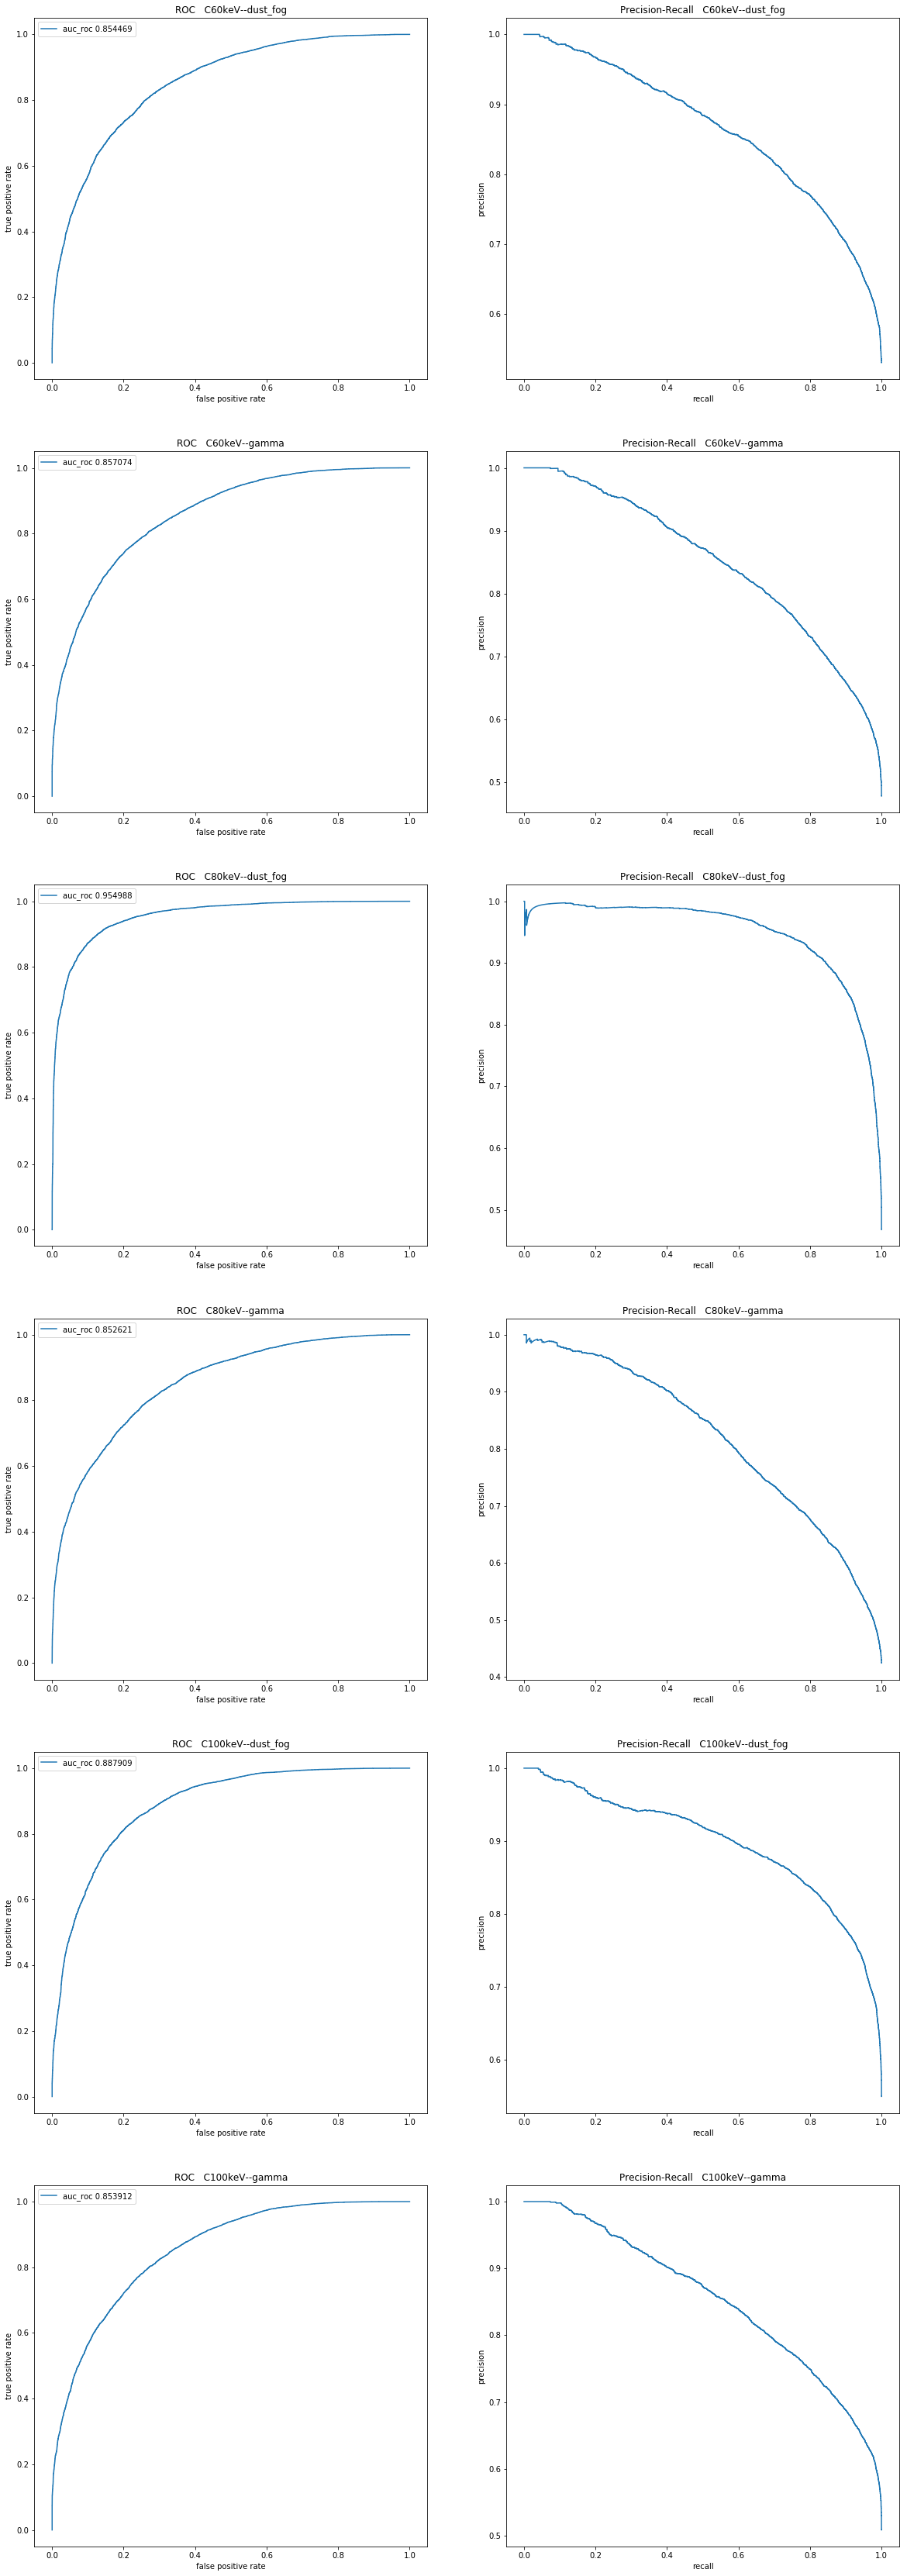

In [34]:
%%time
# Taking the best number of estimators from CV
boocla.set_params(n_estimators = n_est[np.argmax(giant_scores)])
#boocla = GradientBoostingClassifier(n_estimators=500)

f, axes = plt.subplots(6, 2, figsize=(20, 60))
axes = axes.ravel()
i=0
auc_rocs = {}
##### Creating the pairs of signal-noise for comparison
for name1 in class_names:
    for name2 in class_names:
        if (name1[0] == 'C') and (name2[0] != 'C'):
            input_data = feat_to_input(feat_giant_data, [name1, name2])
            X = input_data.drop(['target'], axis=1).values
            y = input_data.get('target').values
            X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_raw)
            X_test_scaled = scaler.transform(X_test_raw)
            ##### Scoring the BDT and building curves
            boocla.fit(X_train_scaled, y_train)
            boo_pred = (boocla.predict_proba(X_test_scaled))[:,1]
            auc_rocs[name1+'__'+name2] = roc_auc_score(y_test, boo_pred)
            fpr, tpr, thrsh = roc_curve(y_test, boo_pred)
            axes[i].step(fpr, tpr, label='auc_roc '+str(np.around(auc_rocs[name1+'__'+name2], decimals=6)))
            axes[i].set_title('ROC   '+name1+'--'+name2)
            axes[i].set_xlabel('false positive rate')
            axes[i].set_ylabel('true positive rate')
            axes[i].legend()
            i += 1
            prec, rec, thrsh = precision_recall_curve(y_test, boo_pred)
            axes[i].step(rec, prec)
            axes[i].set_title('Precision-Recall   '+name1+'--'+name2)
            axes[i].set_xlabel('recall')
            axes[i].set_ylabel('precision')
            i += 1
            
            
print 'AUC_ROC scores'
for (key,value) in auc_rocs.iteritems():
    print key,'  \t', np.around(value, decimals=6)

### Training Random Forest

In [35]:
%%time
randcla = RandomForestClassifier()
giant_rand_scores = []
giant_rand_var = []
n_est = [10, 20, 50, 100, 200]
for n in n_est:
    randcla.set_params(n_estimators=n)
    sco = cross_val_score(randcla, X_giant_train_scaled, y_giant_train, scoring=prec_scorer, n_jobs=2, cv=5)
    giant_rand_scores.append(sco.mean())
    giant_rand_var.append(sco.var())
    print np.around(sco.mean(),decimals=3), '+/-', np.around(100*sco.var()/sco.mean(), decimals=3), '%'

0.983 +/- 0.0 %
0.983 +/- 0.0 %
0.982 +/- 0.0 %
0.982 +/- 0.0 %
0.982 +/- 0.0 %
Wall time: 1h 4min 10s


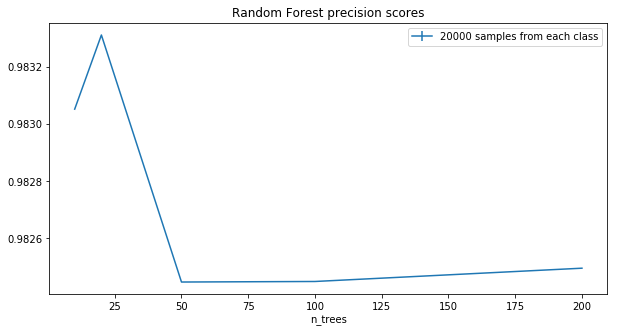

In [36]:
n_est = [10, 20, 50, 100, 200]
plt.figure(figsize=(10,5))
plt.errorbar(n_est, giant_rand_scores, yerr=giant_rand_var, label='20000 samples from each class')
plt.title('Random Forest precision scores')
plt.xlabel('n_trees')
plt.legend()
plt.savefig('RF_cv_20k.pdf')

In [37]:
%%time
randcla.set_params(n_estimators=100)
sco = cross_val_score(randcla, X_train_scaled, y_train, scoring='accuracy', n_jobs=3, cv=5)
print 'RF accuracy', np.around(sco.mean(),decimals=3), '+/-', np.around(100*sco.var()/sco.mean(), decimals=3), '%'

RF accuracy 0.988 +/- 0.0 %
Wall time: 3min 7s


##### AUC-ROC and Precision-Recall curves

AUC_ROC scores
C60keV__dust_fog   	0.9996964
C60keV__gamma   	0.9995793
C80keV__gamma   	0.999422
C80keV__dust_fog   	0.9995288
C100keV__gamma   	0.9997115
C100keV__dust_fog   	0.9998296
Wall time: 3min 34s


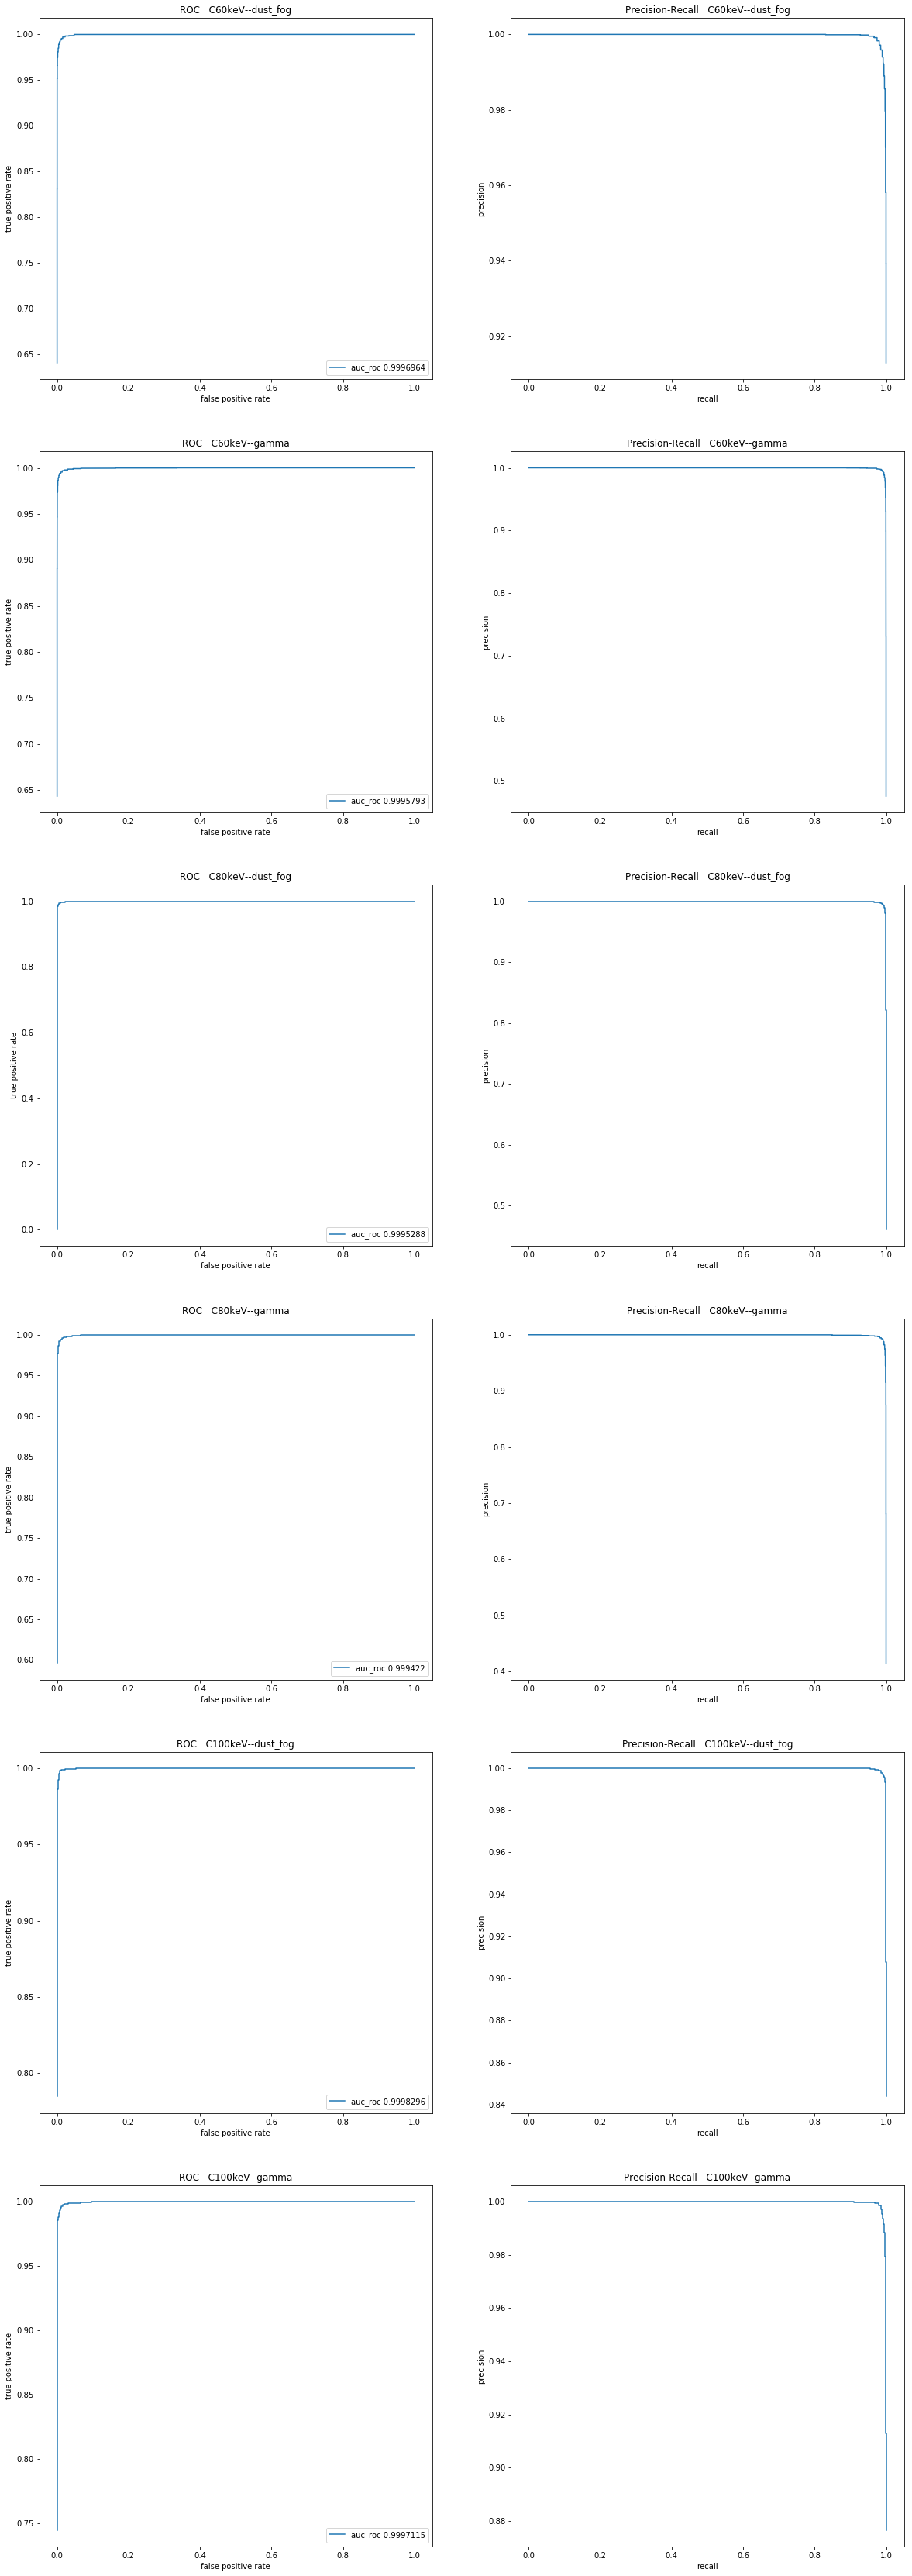

In [38]:
%%time
# Taking the best number of estimators from CV
randcla.set_params(n_estimators = n_est[np.argmax(giant_rand_scores)])
#randcla = RandomForestClassifier(n_estimators=100)

f, axes = plt.subplots(6, 2, figsize=(20, 60))
axes = axes.ravel()
i=0
auc_rocs = {}
##### Creating the pairs of signal-noise for comparison
for name1 in class_names:
    for name2 in class_names:
        if (name1[0] == 'C') and (name2[0] != 'C'):
            input_data = feat_to_input(feat_giant_data, [name1, name2])
            X = input_data.drop(['target'], axis=1).values
            y = input_data.get('target').values
            X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_raw)
            X_test_scaled = scaler.transform(X_test_raw)
            ##### Scoring the RF and building curves
            randcla.fit(X_train_scaled, y_train)
            rand_pred = (randcla.predict_proba(X_test_scaled))[:,1]
            auc_rocs[name1+'__'+name2] = roc_auc_score(y_test, rand_pred)
            fpr, tpr, thrsh = roc_curve(y_test, rand_pred)
            axes[i].step(fpr, tpr, label='auc_roc '+str(np.around(auc_rocs[name1+'__'+name2], decimals=7)))
            axes[i].set_title('ROC   '+name1+'--'+name2)
            axes[i].set_xlabel('false positive rate')
            axes[i].set_ylabel('true positive rate')
            axes[i].legend()
            i += 1
            prec, rec, thrsh = precision_recall_curve(y_test, rand_pred)
            axes[i].step(rec, prec)
            axes[i].set_title('Precision-Recall   '+name1+'--'+name2)
            axes[i].set_xlabel('recall')
            axes[i].set_ylabel('precision')
            i += 1
            
            
print 'AUC_ROC scores'
for (key,value) in auc_rocs.iteritems():
    print key,'  \t', np.around(value, decimals=7)

## Example of one image fit

In [7]:
imgs = pd.read_csv('D:/NEWSdm/crops/dust_fog/0_cluster_1.csv', header=None).drop(30, axis=1)
imgs.head(3)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,27,27,27,27,27,27,26,25,26,26,...,23,23,24,24,23,22,22,24,22,23
1,28,28,29,28,27,28,29,28,27,27,...,25,23,23,23,24,23,23,22,23,23
2,30,29,30,29,30,29,30,29,29,28,...,24,24,23,24,24,23,23,24,24,22


(8L, 30L, 30L)


[]

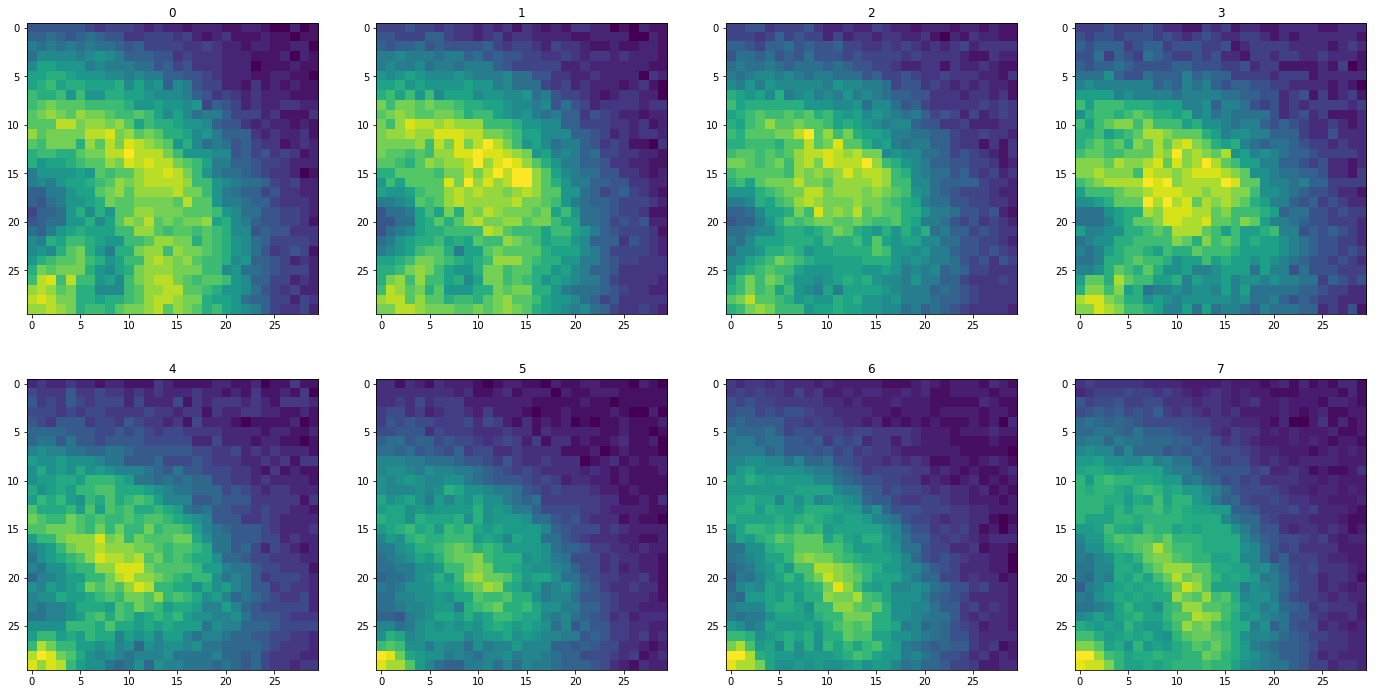

In [8]:
img_re = imgs.values.reshape((8,30,30), order='C')
print img_re.shape

f, axes = plt.subplots(2, 4,figsize=(24, 12))

for key, ax in zip(range(img_re.shape[0]), axes.ravel()):
    
    ax.imshow(img_re[key, : ,:])
    ax.set_title(key)
plt.plot()

In [9]:
data = img_re[3]

In [10]:
%%time
par = fit_gaussian(data)
#print par

Wall time: 52 ms


##### Victor's idea of making coordinates grid for passing to Gaussian.

>sp.stack(sp.meshgrid(sp.array([1,2,3]), sp.array([1,2,3])), axis=-1)

    array([[[1, 1],
            [2, 1],
            [3, 1]],

           [[1, 2],
            [2, 2],
            [3, 2]],

           [[1, 3],
            [2, 3],
            [3, 3]]])

[]

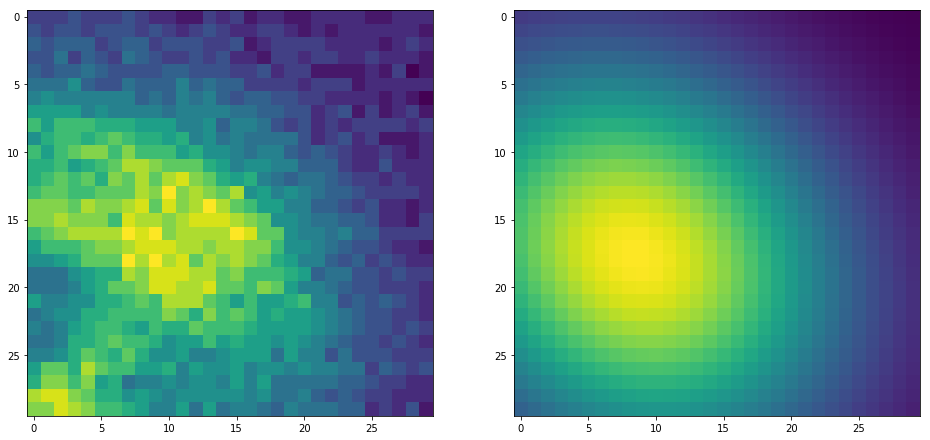

In [11]:
_, (ax1,ax2) = plt.subplots(1,2, figsize=(16,8))
ax1.imshow(data)
ax2.imshow( twod_gaussian(*par)(np.stack(np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1])), axis=-1)) )
plt.plot()
#plt.savefig('divergent.png')

# TESTING ZONE

##### <font color='red'> RANDOM CODE HAPPENS </font>

In [117]:
print time.time()-timing ,'\n\n', data_params['C60keV'].max().append(data_params['C60keV'].min())
print data_params['C60keV'].shape

1495.99600005 

img_num      1000.000000
polar           7.000000
height        168.076394
amplitude     436.203508
center_x       50.453217
center_y       47.509845
sig_x         498.733469
sig_y         499.262712
sig_xy        230.548305
img_num         1.000000
polar           0.000000
height         -0.004468
amplitude       0.129574
center_x       -0.080951
center_y       -0.060784
sig_x           0.732974
sig_y           2.234670
sig_xy       -385.420630
dtype: float64
(5628, 9)


In [58]:
print data_params['C60keV']['height'].min(),'\n', data_params['C60keV']['height'].argmin()

168.111234705 
934


In [90]:
data_params['C60keV'].loc[935]

img_num      117.000000
polar          7.000000
height       167.556910
amplitude     92.352334
center_x      28.769587
center_y      13.241359
sig_x         41.622032
sig_y        112.949711
sig_xy       -51.489011
Name: 935, dtype: float64

In [139]:
data = data_imgs['C60keV'][105,6]
p = fit_gaussian(data)
par = pd.DataFrame(data=p.reshape((1,len(p))), columns=['height', 'amplitude', 'center_x', 'center_y', 'sig_x', 'sig_y', 'sig_xy'])
print par, '\n\n', data.max(), data.min()

      height     amplitude    center_x    center_y         sig_x        sig_y  \
0  40.512849  1.308045e+06 -579.521387 -122.895719  18729.344113  1314.124211   

        sig_xy  
0  4700.480661   

210 37


Wall time: 374 ms


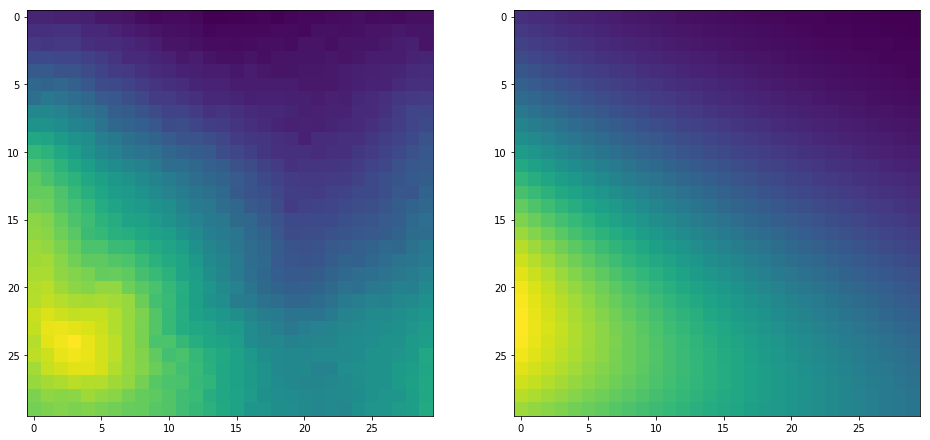

In [140]:
%%time
_, (ax1,ax2) = plt.subplots(1,2, figsize=(16,8))
ax1.imshow(data)
ax2.imshow( twod_gaussian(*p)(np.stack(np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1])), axis=-1)) )
plt.plot()
#plt.savefig('crazy.png')